<a href="https://www.kaggle.com/code/pratik150507/mining-imdb-for-movie-trends-by-pratik?scriptVersionId=284113891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install efficient_apriori
!pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import os

df =  pd.read_csv('/kaggle/input/movies/movies.csv') 
df.head()


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


In [4]:
duplicates = df.columns[df.columns.duplicated()].tolist()

In [5]:
df.isna().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

#  Handling Missing Values :

In [6]:
df = df.copy()

df['rating'] = df['rating'].fillna("Unknown Rating")
df['writer'] = df['writer'].fillna("Unknown Writer")
df['star'] = df['star'].fillna("Unknown Star")
df['company'] = df['company'].fillna("Unknown Company")

df['votes'] = df['votes'].fillna(0)
df['runtime'] = df['runtime'].fillna(df['runtime'].median())

df['budget'] = df['budget'].fillna(df['budget'].median())
df['gross']  = df['gross'].fillna(df['gross'].median())

df = df.dropna(subset=['score','country']) 

df.isna().sum()

name        0
rating      0
genre       0
year        0
released    0
score       0
votes       0
director    0
writer      0
star        0
country     0
budget      0
gross       0
company     0
runtime     0
dtype: int64

# PERFORMANCE CLASS

In [7]:
df['profit_ratio'] = df['gross'] / df['budget'].replace(0, np.nan)
def categorize_performance(r):
    if pd.isna(r):
        return "Unknown Performance" #budget == 0 case 
    if r < 1: return "Flop"
    elif r < 1.5: return "Average"
    elif r < 3: return "Hit"
    elif r < 5: return "Super Hit"
    elif r < 8: return "Blockbuster"
    else: return "All-Time Blockbuster"

df['performance_class'] = df['profit_ratio'].apply(categorize_performance)
df = df[df['performance_class'] != "Unknown Performance"]
df['performance_class'].count()

7662

In [8]:
bb = df[df['performance_class'] == "All-Time Blockbuster"]
bb.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,profit_ratio,performance_class
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,13.078468,All-Time Blockbuster
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,29.909726,All-Time Blockbuster
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,23.843868,All-Time Blockbuster
5,Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0,72.281093,All-Time Blockbuster
13,Ordinary People,R,Drama,1980,"September 19, 1980 (United States)",7.7,49000.0,Robert Redford,Judith Guest,Donald Sutherland,United States,6000000.0,54766923.0,Paramount Pictures,124.0,9.127821,All-Time Blockbuster


# SCORE CATEGORY

In [9]:
def score_category(x):
    if x >= 8:
        return "Excellent"
    elif x >= 7:
        return "Very Good"
    elif x >= 6:
        return "Good"
    elif x >= 5:
        return "Average"
    elif x > 0:
        return "Poor"
    else:
        return "MissingScore"     # missing or 0 score
df["score_cat"] = df["score"].apply(score_category)


df["score_cat"].head()

0    Excellent
1      Average
2    Excellent
3    Very Good
4    Very Good
Name: score_cat, dtype: object

In [10]:
def classify_budget(b):  #us standards
    if b == 0: return "unknown Budget"
    elif b < 5_000_000: return "Low Budget"
    elif b < 50_000_000: return "Mid Budget"
    else: return "High Budget"

df["budget_cat"] = df["budget"].apply(classify_budget)

df["budget_cat"] 


0       Mid Budget
1       Low Budget
2       Mid Budget
3       Low Budget
4       Mid Budget
           ...    
7660    Mid Budget
7663    Low Budget
7664    Mid Budget
7665    Low Budget
7667    Mid Budget
Name: budget_cat, Length: 7662, dtype: object

In [11]:
perf_order = ["All-Time Blockbuster", "Blockbuster", "Super Hit", "Hit", "Average", "Flop", "Unknown"]

dir_counts = df.groupby(['director', 'performance_class']).size().reset_index(name='count')
dir_pivot = dir_counts.pivot(index='director', columns='performance_class', values='count').fillna(0)

actor_counts = df.groupby(['star', 'performance_class']).size().reset_index(name='count')
actor_pivot = actor_counts.pivot(index='star', columns='performance_class', values='count').fillna(0)

for c in perf_order:
    if c not in dir_pivot.columns:
        dir_pivot[c] = 0
    if c not in actor_pivot.columns:
        actor_pivot[c] = 0

weights = {
    "All-Time Blockbuster": 15,
    "Blockbuster": 5,
    "Super Hit": 3,
    "Hit": 2,
    "Average": 1,
    "Flop": 0,
    "Unknown": 0
}

def compute_weighted_score(row):
    return sum(row[k] * w for k, w in weights.items())


dir_pivot['director_success_score'] = dir_pivot.apply(compute_weighted_score, axis=1)
actor_pivot['actor_success_score'] = actor_pivot.apply(compute_weighted_score, axis=1)

# # map back
df['director_success_score'] = df['director'].map(dir_pivot['director_success_score']).fillna(0)
df['actor_success_score'] = df['star'].map(actor_pivot['actor_success_score']).fillna(0)

actor_pivot.sort_values(by='actor_success_score',ascending=False).head(10)


performance_class,All-Time Blockbuster,Average,Blockbuster,Flop,Hit,Super Hit,Unknown,actor_success_score
star,,,,,,,,
Tom Hanks,5.0,2.0,10.0,5.0,10.0,9.0,0,174.0
Tom Cruise,4.0,1.0,4.0,2.0,12.0,11.0,0,138.0
Harrison Ford,5.0,3.0,1.0,7.0,6.0,4.0,0,107.0
Mel Gibson,3.0,3.0,6.0,6.0,8.0,3.0,0,103.0
Arnold Schwarzenegger,3.0,4.0,3.0,4.0,10.0,3.0,0,93.0
Robin Williams,4.0,2.0,1.0,11.0,7.0,2.0,0,87.0
Kevin Costner,3.0,5.0,2.0,8.0,7.0,4.0,0,86.0
Jim Carrey,2.0,0.0,4.0,2.0,8.0,6.0,0,84.0
Sylvester Stallone,2.0,3.0,3.0,9.0,9.0,6.0,0,84.0


In [12]:
dir_pivot.sort_values(by='director_success_score',ascending=False).head(10)

performance_class,All-Time Blockbuster,Average,Blockbuster,Flop,Hit,Super Hit,Unknown,director_success_score
director,,,,,,,,
Steven Spielberg,7.0,2.0,3.0,1.0,5.0,9.0,0,159.0
Clint Eastwood,3.0,1.0,4.0,6.0,11.0,6.0,0,106.0
Chris Columbus,5.0,1.0,1.0,4.0,2.0,2.0,0,91.0
Robert Zemeckis,4.0,2.0,2.0,1.0,6.0,2.0,0,90.0
James Wan,5.0,1.0,2.0,1.0,0.0,0.0,0,86.0
Hayao Miyazaki,5.0,0.0,1.0,0.0,0.0,1.0,0,83.0
Ivan Reitman,4.0,2.0,2.0,1.0,5.0,0.0,0,82.0
M. Night Shyamalan,4.0,1.0,1.0,1.0,2.0,3.0,0,79.0
Ron Howard,2.0,4.0,4.0,4.0,6.0,4.0,0,78.0


In [13]:
def categorize_director(score):
    if score >= 30:
        return "Legendary-Director"
    elif score >= 15:
        return "High-Performer-Director"
    elif score >= 5:
        return "Medium-Director"
    else:
        return "Low-Director"

df['director_category'] = df['director_success_score'].apply(categorize_director)


In [14]:
def categorize_actor(score):
    if score >= 40:
        return "Legendary-Actor"
    elif score >= 20:
        return "High-Performer-Actor"
    elif score >= 8:
        return "Mid-Actor"
    else:
        return "Low-Actor"
df['actor_category'] = df['actor_success_score'].apply(categorize_actor)

In [15]:
df['director'].value_counts().head(10)

director
Woody Allen          38
Clint Eastwood       31
Directors            27
Steven Spielberg     27
Ron Howard           24
Ridley Scott         23
Steven Soderbergh    23
Joel Schumacher      22
Barry Levinson       20
Tim Burton           19
Name: count, dtype: int64

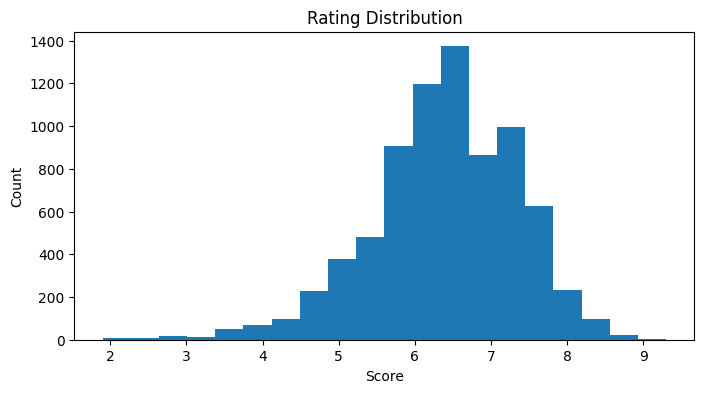

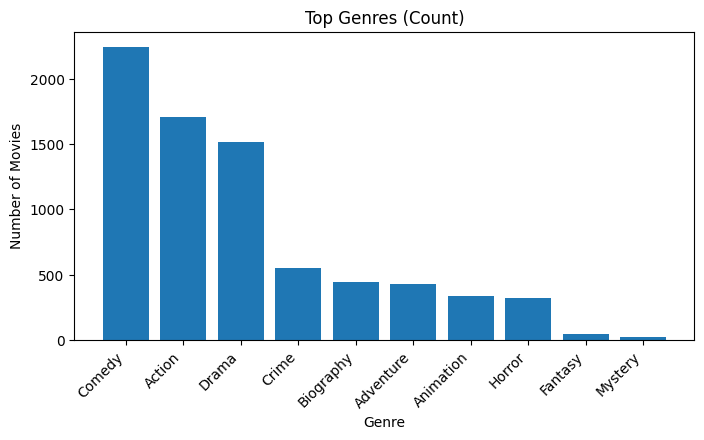

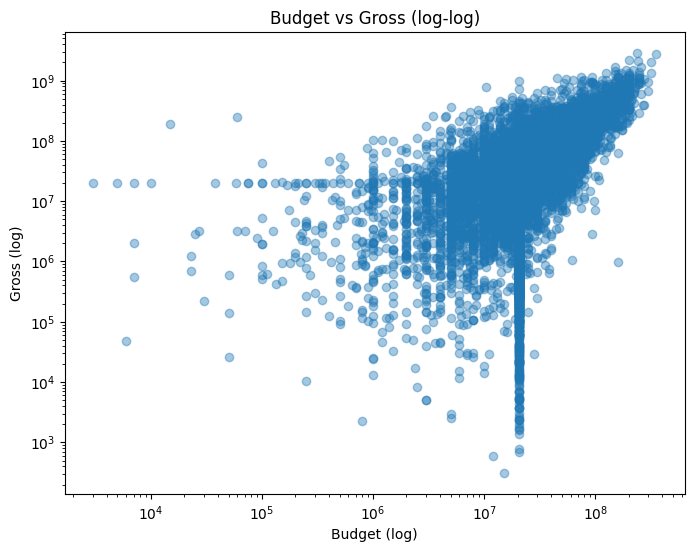

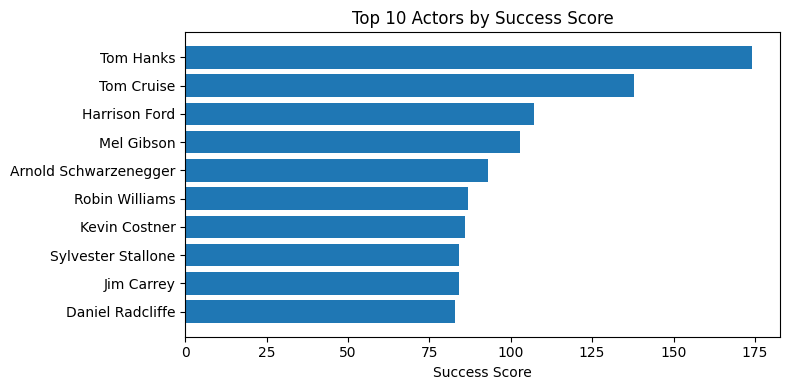

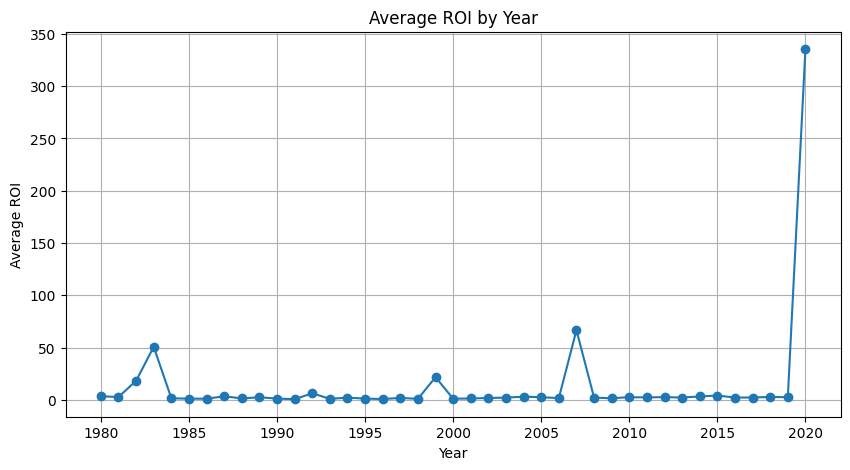

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ 1. Rating Distribution -------------------
plt.figure(figsize=(8,4))
plt.hist(df['score'], bins=20)
plt.title("Rating Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# ------------------ 2. Genre Count -------------------
genre_count = df['genre'].value_counts().head(10)

plt.figure(figsize=(8,4))
plt.bar(genre_count.index, genre_count.values)
plt.title("Top Genres (Count)")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha='right')
plt.show()

# ------------------ 3. Budget vs Gross -------------------
plt.figure(figsize=(8,6))
plt.scatter(df['budget'], df['gross'], alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.title("Budget vs Gross (log-log)")
plt.xlabel("Budget (log)")
plt.ylabel("Gross (log)")
plt.show()

# ------------------ 4. Top Actors by Success Score -------------------
top_actors = (df[['star','actor_success_score']]
              .drop_duplicates(subset='star')
              .sort_values('actor_success_score', ascending=False)
              .head(10))

plt.figure(figsize=(8,4))
plt.barh(top_actors['star'][::-1], top_actors['actor_success_score'][::-1])
plt.title("Top 10 Actors by Success Score")
plt.xlabel("Success Score")
plt.tight_layout()
plt.show()

# ------------------- 5. Year vs Average ROI (Line Graph) ---------------

df['roi'] = (df['gross'] - df['budget']) / df['budget']

year_roi = df.groupby('year')['roi'].mean()

plt.figure(figsize=(10,5))
plt.plot(year_roi.index, year_roi.values, marker='o')
plt.title("Average ROI by Year")
plt.xlabel("Year")
plt.ylabel("Average ROI")
plt.grid(True)
plt.show()



In [17]:
# there are some movies with multiple directors it is writen as Directors in the column director
# it might affect our futhure model
df[df['director'] == 'Directors'].head(5)
df.isna().sum()

name                      0
rating                    0
genre                     0
year                      0
released                  0
score                     0
votes                     0
director                  0
writer                    0
star                      0
country                   0
budget                    0
gross                     0
company                   0
runtime                   0
profit_ratio              0
performance_class         0
score_cat                 0
budget_cat                0
director_success_score    0
actor_success_score       0
director_category         0
actor_category            0
roi                       0
dtype: int64

In [18]:
from efficient_apriori import apriori

df['star'] = 'star_' + df['star'].astype(str)
df['director'] = 'dir_' + df['director'].astype(str)


cols_for_apriori = [
    'genre',
    'performance_class',
    'score_cat',
    'budget_cat',
    'director_category',
    'actor_category',
    'company',
    'star',
    'director'
]



transactions = df[cols_for_apriori].astype(str).values.tolist()


itemsets, rules = apriori(
    transactions,
    min_support=0.01,  #edit to get meaningfull result like 0.01 or 0.001    
    min_confidence=0.3    
)


for rule in sorted(rules, key=lambda x: x.lift, reverse=True)[:10]:
    print(rule)




{High-Performer-Director, Low Budget} -> {All-Time Blockbuster, Mid-Actor} (conf: 0.488, supp: 0.013, lift: 16.385, conv: 1.893)
{All-Time Blockbuster, Mid-Actor} -> {High-Performer-Director, Low Budget} (conf: 0.430, supp: 0.013, lift: 16.385, conv: 1.708)
{High-Performer-Director, Low Budget, Mid-Actor} -> {All-Time Blockbuster} (conf: 0.933, supp: 0.013, lift: 14.245, conv: 14.017)
{Low Budget, Mid-Actor} -> {All-Time Blockbuster, High-Performer-Director} (conf: 0.576, supp: 0.013, lift: 14.202, conv: 2.265)
{All-Time Blockbuster, High-Performer-Director} -> {Low Budget, Mid-Actor} (conf: 0.315, supp: 0.013, lift: 14.202, conv: 1.428)
{Low Budget, Mid-Actor} -> {All-Time Blockbuster} (conf: 0.771, supp: 0.017, lift: 11.761, conv: 4.073)
{High-Performer-Director, Low Budget} -> {All-Time Blockbuster} (conf: 0.701, supp: 0.018, lift: 10.707, conv: 3.131)
{All-Time Blockbuster, Low Budget} -> {High-Performer-Director, Mid-Actor} (conf: 0.495, supp: 0.013, lift: 9.410, conv: 1.876)
{All

In [19]:
rules_df = pd.DataFrame([{
    "lhs": ', '.join(list(rule.lhs)),
    "rhs": ', '.join(list(rule.rhs)),
    "support": rule.support,
    "confidence": rule.confidence,
    "lift": rule.lift
} for rule in rules])

rules_df

,lhs,rhs,support,confidence,lift
0,Action,Average,0.076351,0.343310,1.168046
1,Columbia Pictures,Action,0.014618,0.337349,1.516884
2,Action,Flop,0.078961,0.355047,0.754192
3,Action,Good,0.094101,0.423122,1.031486
4,High Budget,Action,0.079353,0.486011,2.185339
...,...,...,...,...,...
2670,"Drama, Flop, Low-Actor, Low-Director","Mid Budget, Very Good",0.020230,0.320911,1.635941
2671,"Drama, Mid Budget, Very Good","Flop, Low-Actor, Low-Director",0.020230,0.353881,1.655335
2672,"Drama, Low-Director, Very Good","Flop, Low-Actor, Mid Budget",0.020230,0.620000,2.237607
2673,"Drama, Low-Actor, Very Good","Flop, Low-Director, Mid Budget",0.020230,0.547703,1.991695


# 📊 Support vs Confidence Scatter Plot

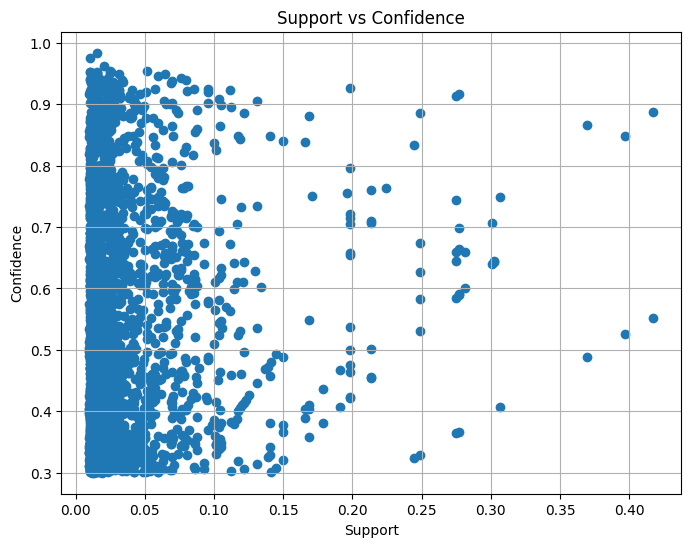

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(rules_df['support'], rules_df['confidence'])
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.grid(True)
plt.show()


# 📊 Support vs Lift Scatter Plot

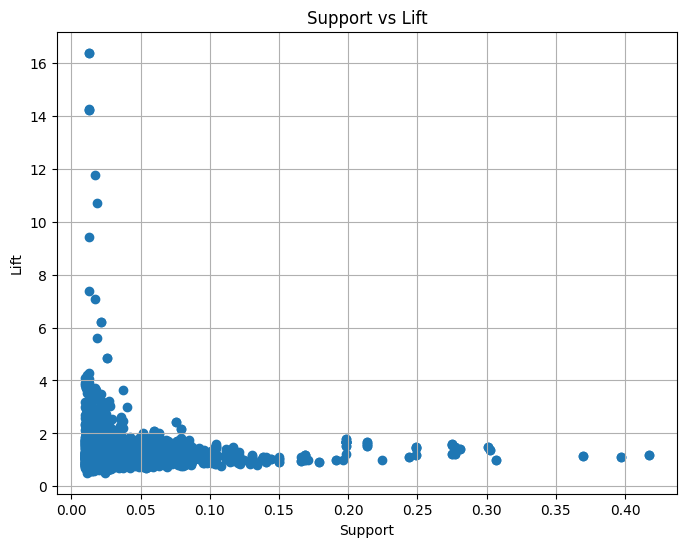

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(rules_df['support'], rules_df['lift'])
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Support vs Lift')
plt.grid(True)
plt.show()

# 📊 Confidence vs Lift Plot

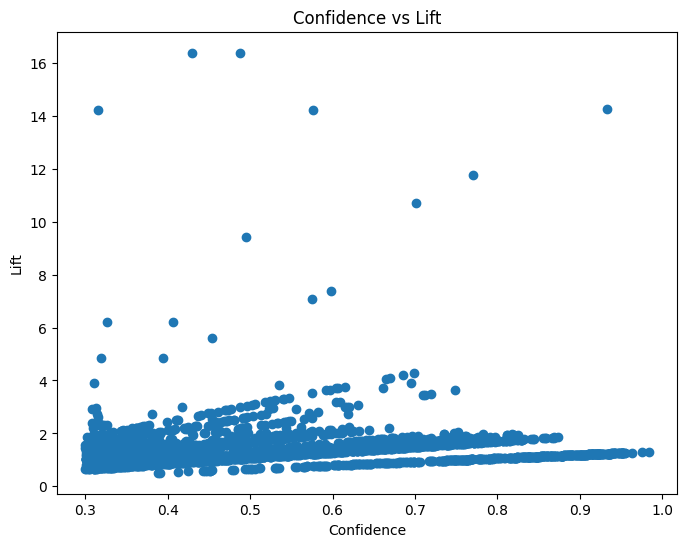

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(rules_df['confidence'], rules_df['lift'])
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Confidence vs Lift')
plt.show()


# Top 20 Rules by Lift

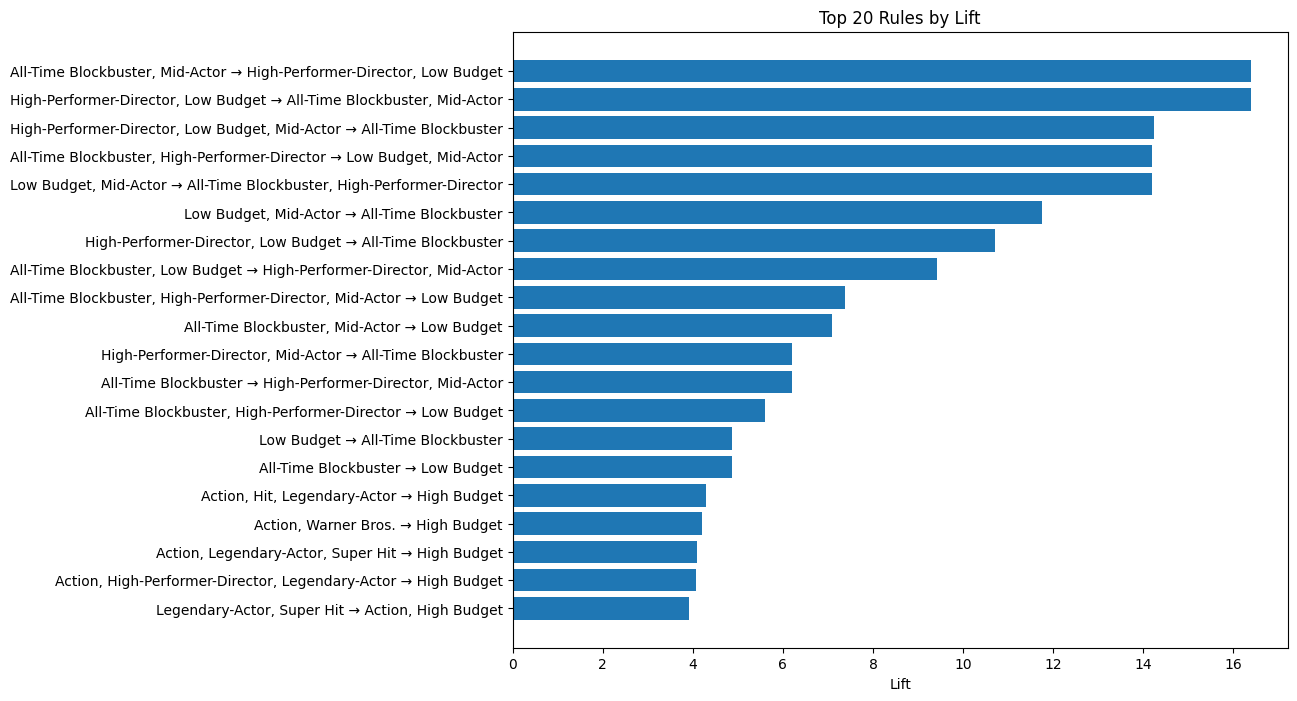

In [23]:
top20 = rules_df.sort_values('lift', ascending=False).head(20)

plt.figure(figsize=(10,8))
plt.barh(top20['lhs'] + " → " + top20['rhs'], top20['lift'])
plt.xlabel('Lift')
plt.title('Top 20 Rules by Lift')
plt.gca().invert_yaxis()
plt.show()


# preprocess for better model

In [24]:
df['performance_class'].value_counts()

performance_class
Flop                    3607
Hit                     1452
Super Hit                883
Average                  738
All-Time Blockbuster     502
Blockbuster              480
Name: count, dtype: int64

In [25]:
df_balanced = df.copy()
def merge_performance(r):
    if r in ['Flop', 'Average']:
        return 'Low/Flop'
    elif r in ['Hit', 'Super Hit']:
        return 'Hit/Success'
    elif r in ['Blockbuster', 'All-Time Blockbuster']:
        return 'Big Hit'

df_balanced['performance_class'] = df_balanced['performance_class'].apply(merge_performance)
df_balanced['performance_class'].value_counts()


performance_class
Low/Flop       4345
Hit/Success    2335
Big Hit         982
Name: count, dtype: int64

# Models


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


features = [
    'budget_cat', 'score_cat', 'director_success_score', 'actor_success_score',
    'genre', 'runtime'
]

target = 'performance_class'



X = df_balanced[features].copy()
y = df_balanced[target].copy()


cat_cols = ['budget_cat', 'score_cat', 'genre']
num_cols = ['director_success_score', 'actor_success_score', 'runtime']


ohe = OneHotEncoder(sparse_output=False, drop='first') #encoding
X_cat = ohe.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(cat_cols), index=X.index)

X = X.drop(columns=cat_cols)
X = pd.concat([X, X_cat_df], axis=1)


scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_accs = []
test_accs = []
depths = range(1, 11)  # depths 1–20

print("Depth | Train Accuracy | Test Accuracy")
print("----------------------------------------")

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, min_samples_leaf=5,random_state=42)
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"{d:>5} | {train_acc:.4f}        | {test_acc:.4f}")

# Best depth based on test accuracy
best_depth = depths[test_accs.index(max(test_accs))]
best_test_acc = max(test_accs)

print("\nBest depth based on test accuracy:", best_depth)
print("Best test accuracy:", best_test_acc)


Depth | Train Accuracy | Test Accuracy
----------------------------------------
    1 | 0.5655        | 0.5714
    2 | 0.6616        | 0.6732
    3 | 0.6804        | 0.6804
    4 | 0.6921        | 0.6928
    5 | 0.6946        | 0.6986
    6 | 0.7013        | 0.7136
    7 | 0.7106        | 0.7038
    8 | 0.7182        | 0.7019
    9 | 0.7372        | 0.7195
   10 | 0.7492        | 0.7241

Best depth based on test accuracy: 10
Best test accuracy: 0.7240704500978473


In [27]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches

# Step 1: One-Hot Encode categorical features
genre_ohe = pd.get_dummies(df['genre'], prefix='genre')
director_ohe = pd.get_dummies(df['director_category'], prefix='dir')
actor_ohe = pd.get_dummies(df['actor_category'], prefix='actor')

# Step 2: Combine all OHE features
feature_matrix = pd.concat([genre_ohe, director_ohe, actor_ohe], axis=1)

# Step 3: Compute cosine similarity using inbuilt function
similarity_matrix = cosine_similarity(feature_matrix)

# Step 4: Recommendation function
def recommend(movie_title, top_n=5):
    # Find closest match
    matches = get_close_matches(movie_title, df['name'].values)
    if not matches:
        return f"Movie '{movie_title}' not found."
    
    idx = df[df['name'] == matches[0]].index[0]
    
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]  # top N similar movies
    return df['name'].iloc[top_indices]

# Test the recommender
print("Recommendations for 'Inception':")
print(recommend("Inception"))

print("\nRecommendations for 'Titanic':")
print(recommend("Titanic"))


print("\nRecommendations for 'Star Wars: Episode V - The Empire Strikes Back':")
print(recommend("Star Wars: Episode V - The Empire Strikes Back"))

Recommendations for 'Inception':
92     Indiana Jones and the Raiders of the Lost Ark
206                                     Blade Runner
233                                          Firefox
359                                    Sudden Impact
475                                   The Terminator
Name: name, dtype: object

Recommendations for 'Titanic':
225        Rocky III
339    Staying Alive
503      The Natural
656       Pale Rider
663         Rocky IV
Name: name, dtype: object

Recommendations for 'Star Wars: Episode V - The Empire Strikes Back':
254                                 Death Wish II
333    Star Wars: Episode VI - Return of the Jedi
394                                Uncommon Valor
524                                    Dreamscape
700                                     Tuff Turf
Name: name, dtype: object
